In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import pandas as pd
from pandas_datareader import data 
import matplotlib.pyplot as plt

sns.set(style='darkgrid', context='talk', palette='Dark2')

Example of web scrapping on Tesla

In [56]:
start_date = '2000-01-01'
end_date = '2022-10-31'
tesla = data.DataReader('TSLA', 'yahoo', start_date, end_date)
tesla

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,1.666667,1.169333,1.266667,1.592667,281494500.0,1.592667
2010-06-30,2.028000,1.553333,1.719333,1.588667,257806500.0,1.588667
2010-07-01,1.728000,1.351333,1.666667,1.464000,123282000.0,1.464000
2010-07-02,1.540000,1.247333,1.533333,1.280000,77097000.0,1.280000
2010-07-06,1.333333,1.055333,1.333333,1.074000,103003500.0,1.074000
...,...,...,...,...,...,...
2022-10-25,224.350006,210.000000,210.100006,222.419998,96507900.0,222.419998
2022-10-26,230.600006,218.199997,219.399994,224.639999,85012500.0,224.639999
2022-10-27,233.809998,222.850006,229.770004,225.089996,61638800.0,225.089996


Having imported the appropriate tools, getting market data from a free online source, such as Yahoo Finance, is super easy. Since pandas has a simple remote data access for the Yahoo Finance API data, this is as simple as:

In [57]:
def web_scrapper():
    tickers = pd.read_csv("CSV/constituents.csv")
    tickers_symbol = tickers['Symbol']

    # Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
    # tickers = ['AAPL', 'MSFT', 'GOOG', 'META']

    # We would like all available data from 01/01/2000 until 12/31/2016.
    start_date = '2000-01-01'
    end_date = '2022-10-31'

    # User pandas_reader.data.DataReader to load the desired data.
    df = data.DataReader(tickers_symbol, 'yahoo', start_date, end_date) # I commented this line because I saved the scrapped data into a .csv

    close = df['Close']
    volume = df['Volume']

    #Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

    #Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')
    volume = volume.reindex(all_weekdays)
    volume = volume.fillna(method='ffill')

    df.to_csv("CSV/sp500.csv",index=False)
    close.to_csv("CSV/sp500-close.csv",index=False)
    volume.to_csv("CSV/sp500-volume.csv", index=False)


In [58]:
# web_scrapper()

In [59]:
sp500 = pd.read_csv("CSV/sp500.csv")
close = pd.read_csv("CSV/sp500-close.csv")
volume = pd.read_csv("CSV/sp500-volume.csv")

/home/joaodocarglass/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,2

In [60]:
close

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,BF.B,CERN,DISCA,DISCK,INFO,KSU,PBCT,VIAC,WLTW,XLNX
0,47.187500,3.614583,15.711531,NaN,18.250000,NaN,1.369792,10.884354,16.390625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,45.312500,3.562500,15.262630,NaN,17.812500,NaN,1.328125,10.770975,15.015625,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,46.625000,3.552083,15.234574,NaN,18.000000,NaN,1.333333,10.600907,15.312500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50.375000,3.500000,15.767643,NaN,18.031250,NaN,1.307292,10.657596,15.437500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,51.375000,3.645833,15.935981,NaN,17.937500,NaN,1.343750,10.827664,16.187500,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,118.500000,52.099998,97.949997,149.820007,264.290009,280.609985,72.500000,91.139999,323.790009,181.399994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5952,122.699997,51.950001,98.419998,152.509995,268.250000,279.869995,72.480003,93.589996,320.480011,181.809998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5953,122.800003,51.900002,96.930000,153.500000,267.579987,278.839996,72.500000,94.129997,318.649994,188.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5954,126.599998,54.380001,99.489998,147.610001,258.059998,287.779999,72.849998,94.879997,325.679993,190.669998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
sp500

,Adj Close,Adj Close.1,Adj Close.2,Adj Close.3,Adj Close.4,Adj Close.5,Adj Close.6,Adj Close.7,Adj Close.8,Adj Close.9,...,Volume.495,Volume.496,Volume.497,Volume.498,Volume.499,Volume.500,Volume.501,Volume.502,Volume.503,Volume.504
0,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,BF.B,CERN,DISCA,DISCK,INFO,KSU,PBCT,VIAC,WLTW,XLNX
1,26.166324615478516,2.3924317359924316,9.262775421142578,NaN,18.25,NaN,1.214421033859253,6.651976108551025,16.27467155456543,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.126602172851562,2.357959508895874,8.998124122619629,NaN,17.8125,NaN,1.1774803400039673,6.582683086395264,14.90939998626709,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25.854413986206055,2.3510632514953613,8.981585502624512,NaN,18.0,NaN,1.1820976734161377,6.478750228881836,15.20417594909668,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27.933866500854492,2.3165905475616455,9.295854568481445,NaN,18.03125,NaN,1.1590105295181274,6.5133957862854,15.328289985656738,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5742,122.699997,51.649712,98.419998,152.509995,268.25,279.869995,72.480003,93.589996,320.480011,181.809998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5743,122.800003,51.600002,96.93,153.5,267.579987,278.839996,72.5,94.129997,318.649994,188.080002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5744,126.599998,54.380001,99.489998,147.610001,258.059998,287.779999,72.849998,94.879997,325.679993,190.669998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5745,125.790001,54.779999,98.940002,146.399994,252.080002,283.899994,72.800003,96.980003,318.5,189.919998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
sp500['Close']

0              MMM
1          47.1875
2          45.3125
3           46.625
4           50.375
           ...    
5742    122.699997
5743    122.800003
5744    126.599998
5745    125.790001
5746           NaN
Name: Close, Length: 5747, dtype: object

#### Preparing the Data

Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

In [63]:
close.describe()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,BF.B,CERN,DISCA,DISCK,INFO,KSU,PBCT,VIAC,WLTW,XLNX
count,5956.000000,5956.000000,5956.000000,2564.000000,5956.000000,5553.000000,5956.000000,5956.000000,5956.000000,5458.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,113.436917,23.386101,42.339662,81.229267,84.367363,94.371731,26.071356,34.290448,115.506418,91.040900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,52.216635,22.390187,30.158209,29.263597,113.831002,86.116183,27.039692,16.390569,151.700765,61.189375,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,39.500000,1.958333,13.298689,33.709999,2.350000,11.850000,0.471354,7.916667,8.350000,12.526667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,74.115002,5.201667,22.381470,59.420000,11.267500,30.280001,6.412500,23.410000,28.337031,37.189999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,87.820000,9.955000,26.854405,73.205002,19.730000,58.970001,12.160000,33.815001,38.635000,71.380001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,160.605003,44.937499,47.439999,97.607498,123.544998,126.550003,43.610001,43.402501,117.822500,150.207504,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,258.630005,85.849998,141.460007,174.960007,449.750000,415.420013,103.809998,98.220001,688.369995,241.910004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
volume.describe()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,BF.B,CERN,DISCA,DISCK,INFO,KSU,PBCT,VIAC,WLTW,XLNX
count,5.956000e+03,5.956000e+03,5.956000e+03,2.564000e+03,5.956000e+03,5.553000e+03,5.956000e+03,5.956000e+03,5.956000e+03,5.458000e+03,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,3.386823e+06,1.256532e+06,9.756986e+06,7.759787e+06,3.311174e+05,2.899501e+06,9.416834e+06,3.851787e+06,5.291668e+06,1.161287e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.325338e+06,1.128362e+06,6.265537e+06,5.217398e+06,3.990521e+05,2.518686e+06,8.018340e+06,2.664407e+06,4.198579e+06,9.436873e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,6.510000e+05,3.000000e+04,1.067700e+06,1.378600e+06,0.000000e+00,1.811000e+05,3.348000e+05,3.220000e+05,5.892000e+05,9.000000e+03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2.151100e+06,6.656250e+05,5.573000e+06,5.075550e+06,1.256000e+05,1.803400e+06,5.361758e+06,2.128750e+06,2.677300e+06,6.755250e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,2.860150e+06,1.047000e+06,7.990622e+06,6.605450e+06,2.408000e+05,2.398600e+06,7.589150e+06,3.219300e+06,4.335600e+06,9.415500e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,3.933375e+06,1.577700e+06,1.214370e+07,9.126700e+06,4.138000e+05,3.376300e+06,1.099620e+07,4.830375e+06,6.598500e+06,1.363425e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,5.053240e+07,3.248830e+07,7.810838e+07,1.227402e+08,1.094450e+07,8.965590e+07,2.251328e+08,5.241480e+07,1.087524e+08,1.974950e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
def close_print(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    close = df['Close']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')

    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = close.loc[:, i]

        # Calculate the 20 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=20).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted closing price ($)')
        ax.legend()
    close.to_csv("CSV/close.csv", index=True)


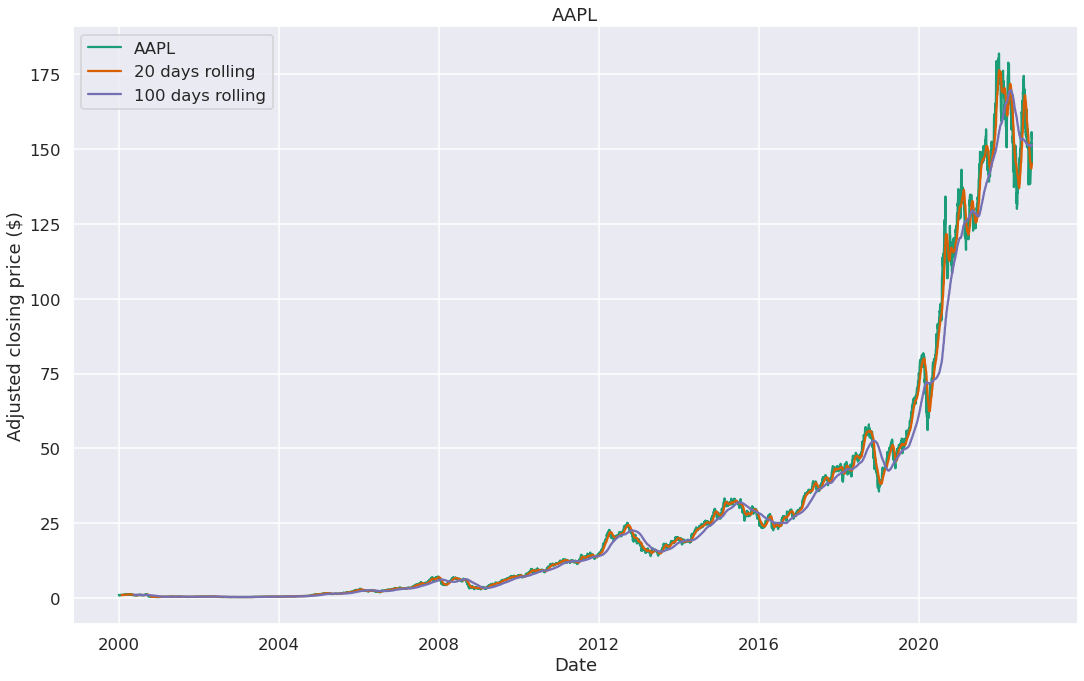

In [66]:
close_print(['AAPL'])

In [67]:
def volume_print(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    volume = df['Volume']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    volume = volume.reindex(all_weekdays)
    volume = volume.fillna(method='ffill')


    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = volume.loc[:, i]

        # Calculate the 30 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=30).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # short_rolling_ticker = ticker.rolling(window=30, center=True).mean()
        # long_rolling_ticker = ticker.rolling(window=100, center=True).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='30 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Volume')
        ax.legend()

    volume.to_csv("CSV/volume.csv", index=True)


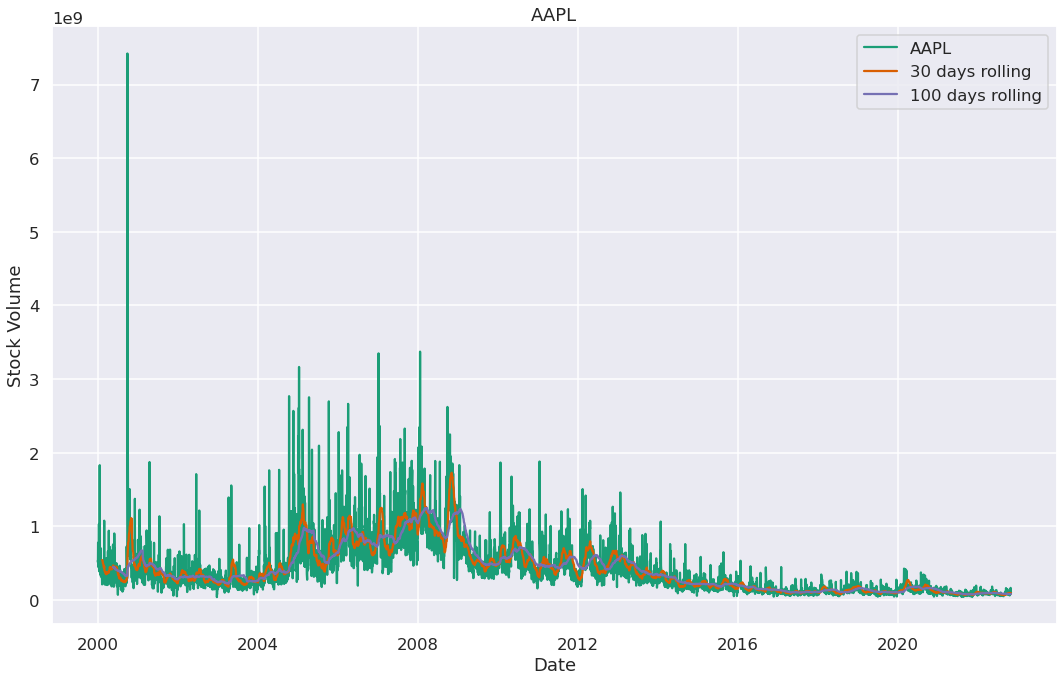

In [68]:
volume_print(['AAPL'])

In [69]:
# Relative returns
returns = close.pct_change(1)
returns.head()

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,BF.B,CERN,DISCA,DISCK,INFO,KSU,PBCT,VIAC,WLTW,XLNX
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.039735,-0.014409,-0.028571,NaN,-0.023973,NaN,-0.030418,-0.010417,-0.083889,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.028966,-0.002924,-0.001838,NaN,0.010526,NaN,0.003921,-0.015789,0.019771,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.080429,-0.014663,0.034991,NaN,0.001736,NaN,-0.019531,0.005347,0.008163,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.019851,0.041667,0.010676,NaN,-0.005199,NaN,0.027888,0.015958,0.048583,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Log returns - First the logarithm of the prices is taken and the the difference of consecutive (log) observations
log_returns = np.log(close).diff()
log_returns.head()


,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,AAP,...,BF.B,CERN,DISCA,DISCK,INFO,KSU,PBCT,VIAC,WLTW,XLNX
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-0.040546,-0.014514,-0.028987,NaN,-0.024265,NaN,-0.030891,-0.010471,-0.087618,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.028554,-0.002928,-0.001840,NaN,0.010471,NaN,0.003914,-0.015915,0.019578,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.077358,-0.014771,0.034392,NaN,0.001735,NaN,-0.019724,0.005333,0.008130,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.019657,0.040822,0.010620,NaN,-0.005213,NaN,0.027506,0.015832,0.047440,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


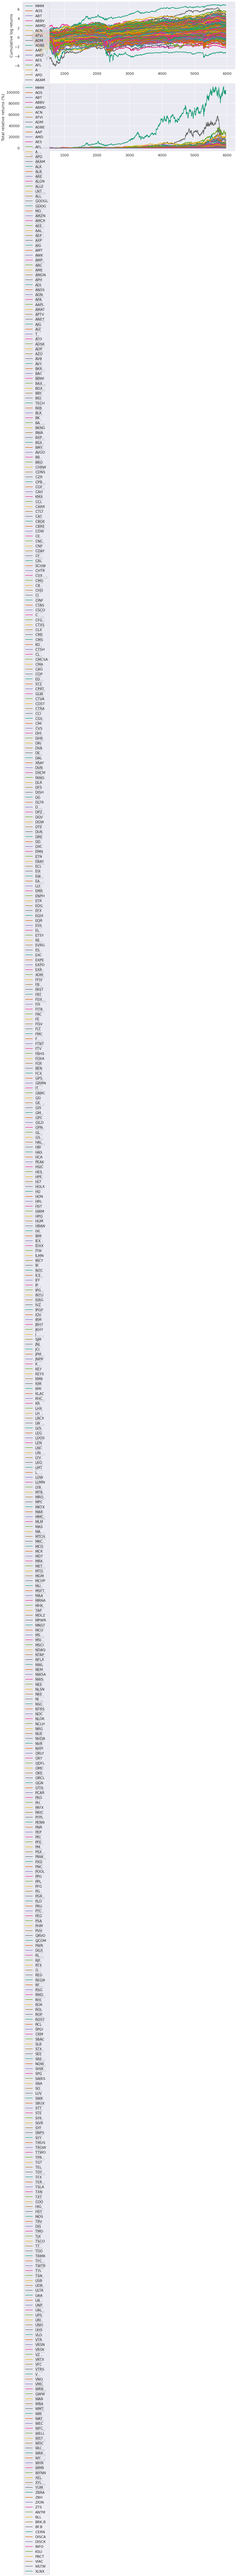

In [71]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,13))

for c in log_returns:
    ax1.plot(log_returns.index, log_returns[c].cumsum(), label=str(c))

ax1.set_ylabel('Cumulative log returns')
ax1.legend(loc='best')

for c in log_returns:
    ax2.plot(log_returns.index, 100*(np.exp(log_returns[c].cumsum()) - 1), label=str(c))

ax2.set_ylabel('Total relative returns (%)')
ax2.legend(loc='best')

plt.show()
